In [1]:
from sklearn.ensemble import AdaBoostClassifier
help(AdaBoostClassifier)

Help on class AdaBoostClassifier in module sklearn.ensemble._weight_boosting:

class AdaBoostClassifier(sklearn.base.ClassifierMixin, BaseWeightBoosting)
 |  AdaBoostClassifier(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
 |  
 |  An AdaBoost classifier.
 |  
 |  An AdaBoost [1] classifier is a meta-estimator that begins by fitting a
 |  classifier on the original dataset and then fits additional copies of the
 |  classifier on the same dataset but where the weights of incorrectly
 |  classified instances are adjusted such that subsequent classifiers focus
 |  more on difficult cases.
 |  
 |  This class implements the algorithm known as AdaBoost-SAMME [2].
 |  
 |  Read more in the :ref:`User Guide <adaboost>`.
 |  
 |  .. versionadded:: 0.14
 |  
 |  Parameters
 |  ----------
 |  base_estimator : object, default=None
 |      The base estimator from which the boosted ensemble is built.
 |      Support for sample weighting is requi

In [4]:
from sklearn.model_selection import validation_curve
help(validation_curve)

Help on function validation_curve in module sklearn.model_selection._validation:

validation_curve(estimator, X, y, *, param_name, param_range, groups=None, cv=None, scoring=None, n_jobs=None, pre_dispatch='all', verbose=0, error_score=nan, fit_params=None)
    Validation curve.
    
    Determine training and test scores for varying parameter values.
    
    Compute scores for an estimator with different values of a specified
    parameter. This is similar to grid search with one parameter. However, this
    will also compute training scores and is merely a utility for plotting the
    results.
    
    Read more in the :ref:`User Guide <validation_curve>`.
    
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    
    X : array-like of shape (n_samples, n_features)
        Training vector, where `n_samples` is the number of samples and
        `n_features` is 

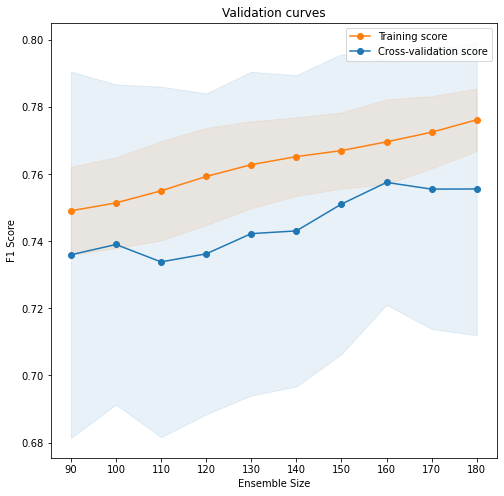

In [2]:
# --- 第 1 部分 ---
# 載入函式庫與資料集
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

np.random.seed(123456)
data = pd.read_csv('../Data/creditcard.csv')
data.Time = (data.Time-data.Time.min())/data.Time.std()
data.Amount = (data.Amount-data.Amount.mean())/data.Amount.std()

# 把資料分為 70% 訓練資料集與 30% 測試資料集
x_train, x_test, y_train, y_test = train_test_split(data.drop('Class', axis = 1).values, 
                                                    data.Class.values, 
                                                    test_size = 0.3)

# --- 第 2 部分 ---
# 計算訓練資料集以及驗證資料集準確率
x, y = x_train, y_train
learner = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), # 輸入弱學習器
                             algorithm="SAMME")                     # 計算權重的方法 SAMME使用預測類別、SAMME.R使用預測機率

param_range = [x for x in range(90, 181, 10)]
train_scores, test_scores = validation_curve(learner,    # 模型
                                             x,          # 資料集的特徵 
                                             y,          # 資料集的標籤
                                             param_name = 'n_estimators', # 欲調整的超參數;指定要訓練多少弱學習器
                                             param_range=param_range,     # 超參數的範圍 
                                             cv = 10,                     # 交叉驗證的折數
                                             scoring = "f1",              # 評價指標
                                             n_jobs = -1)                 # 使用的CPU核心數;-1用全部

# --- 第 3 部分 ---
# 對每個超參數計算模型準確率的平均數與標準差
train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
test_scores_std = np.std(test_scores, axis = 1)


# --- 第 4 部分 ---
# 繪製折線圖
plt.figure(figsize = (8, 8))
plt.title('Validation curves')
# 繪製標準差
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha = 0.1,
                 color="C1")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha = 0.1, color = "C0")

# 繪製平均數
plt.plot(param_range, train_scores_mean, 'o-', color = "C1",
         label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color = "C0",
         label="Cross-validation score")

plt.xticks(param_range)
plt.xlabel('Ensemble Size')
plt.ylabel('F1 Score')
plt.legend(loc="best")

In [3]:
# --- 第 5 部分 ---
# 進行集成
# 原始訓練資料
ensemble = AdaBoostClassifier(n_estimators = 160,  # 指定要訓練多少弱學習器
                              learning_rate = 1.0)
ensemble.fit(x_train, y_train)
print('原始訓練資料:')
print('AdaBoost f1', metrics.f1_score(y_test, ensemble.predict(x_test)))
print('AdaBoost recall', metrics.recall_score(y_test, ensemble.predict(x_test)))

AdaBoost f1 0.8267716535433071
AdaBoost recall 0.7720588235294118


In [4]:
# --- 第 6 部分 ---
# 過濾低相關性的資料
# 篩選特徵
threshold = 0.1

correlations = data.corr()['Class'].drop('Class')
fs = list(correlations[(abs(correlations)>threshold)].index.values)
fs.append('Class')
data = data[fs]

x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(data.drop('Class', axis=1).values, 
                                                    data.Class.values, 
                                                    test_size=0.3)

ensemble = AdaBoostClassifier(n_estimators = 160, 
                              learning_rate = 1.0)
ensemble.fit(x_train_f, y_train_f)
print('過濾低相關性的資料:')
print('AdaBoost f1', metrics.f1_score(y_test_f, ensemble.predict(x_test_f)))
print('AdaBoost recall', metrics.recall_score(y_test_f, ensemble.predict(x_test_f)))

過濾低相關性的資料:
AdaBoost f1 0.8169014084507042
AdaBoost recall 0.8169014084507042


In [5]:
# --- 第 7 部分 ---
# 增加學習率到1.3

# 原始訓練資料
ensemble = AdaBoostClassifier(n_estimators=160, learning_rate=1.3)
ensemble.fit(x_train, y_train)
print('原始訓練資料:')
print('AdaBoost f1', metrics.f1_score(y_test, ensemble.predict(x_test)))
print('AdaBoost recall', metrics.recall_score(y_test, ensemble.predict(x_test)))

# 過濾低相關性的資料
ensemble = AdaBoostClassifier(n_estimators=160, learning_rate=1.3)
ensemble.fit(x_train_f, y_train_f)
print('過濾低相關性的資料:')
print('AdaBoost f1', metrics.f1_score(y_test_f, ensemble.predict(x_test_f)))
print('AdaBoost recall', metrics.recall_score(y_test_f, ensemble.predict(x_test_f)))

AdaBoost f1 0.8281250000000001
AdaBoost recall 0.7794117647058824
AdaBoost f1 0.7985347985347986
AdaBoost recall 0.7676056338028169


In [6]:
# --- 第 8 部分 ---
# 增加學習率到1.6
# 原始訓練資料
ensemble = AdaBoostClassifier(n_estimators=160, learning_rate=1.6)
ensemble.fit(x_train, y_train)
print('原始訓練資料:')
print('AdaBoost f1', metrics.f1_score(y_test, ensemble.predict(x_test)))
print('AdaBoost recall', metrics.recall_score(y_test, ensemble.predict(x_test)))

# 過濾低相關性的資料
ensemble = AdaBoostClassifier(n_estimators=160, learning_rate=1.6)
ensemble.fit(x_train_f, y_train_f)
print('過濾低相關性的資料:')
print('AdaBoost f1', metrics.f1_score(y_test_f, ensemble.predict(x_test_f)))
print('AdaBoost recall', metrics.recall_score(y_test_f, ensemble.predict(x_test_f)))

AdaBoost f1 0.8139534883720931
AdaBoost recall 0.7720588235294118
AdaBoost f1 0.7928571428571428
AdaBoost recall 0.7816901408450704


In [7]:
# --- 第 9 部分 ---
# 增加基學習器數量
# 原始訓練資料
ensemble = AdaBoostClassifier(n_estimators=320, learning_rate=1.3)
ensemble.fit(x_train, y_train)
print('原始訓練資料:')
print('AdaBoost f1', metrics.f1_score (y_test, ensemble.predict(x_test)))
print('AdaBoost recall', metrics.recall_score(y_test, ensemble.predict(x_test)))

# 過濾低相關性的資料
ensemble = AdaBoostClassifier(n_estimators=320, learning_rate=1.3)
ensemble.fit(x_train_f, y_train_f)
print('過濾低相關性的資料:')
print('AdaBoost f1', metrics.f1_score(y_test_f, ensemble.predict(x_test_f)))
print('AdaBoost recall', metrics.recall_score(y_test_f, ensemble.predict(x_test_f)))

AdaBoost f1 0.8093385214007782
AdaBoost recall 0.7647058823529411
AdaBoost f1 0.8265682656826567
AdaBoost recall 0.7887323943661971
